# Online Joint State and Parameters Estimation for AR SSM 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

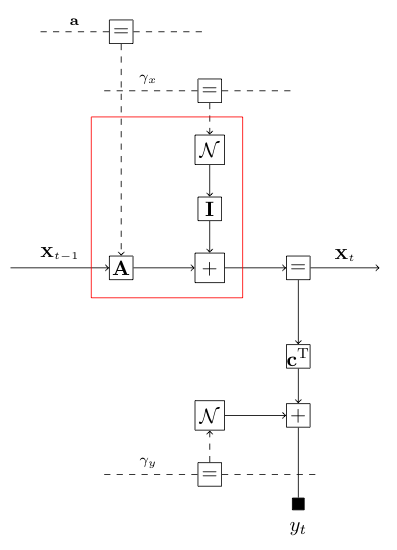

In [2]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, precision of process noise $\gamma_x$ and states $\mathbf{x}_n$, while setting measurement noise precisions $\gamma_y=\frac{1}{2}$.

In [7]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include( "../AR-node/observationAR.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data, generate_sin
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [69]:
ARorder = 2 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
pn_var = a_w/b_w # process noise variance
coefs, x = generate_data(1000, ARorder, 1, noise_variance=pn_var)
#x = use_data("../data/daily-minimum-temperatures.csv", ARorder)
#coefs, x = generate_sin(1000, tiny)
mn_var = 1.0 # measurement noise variance
# Observations
y = [xi[1] + sqrt(mn_var)*randn() for xi in x[ARorder:end]]

999-element Array{Float64,1}:
 -0.6871064461631947 
 -1.1181673482057426 
  1.0265824725595472 
  0.9202649792204081 
 -1.678313616016341  
 -0.768193788226128  
 -0.22710404259469097
 -1.3669490550866006 
 -0.7783804795987561 
 -1.3577723793832985 
  0.4907055663392755 
 -0.22659787577708912
 -1.3357383835792316 
  ⋮                  
  1.6052534361239814 
  1.5115752715116035 
  0.21330397550306435
 -2.388846402231289  
 -2.463812076007371  
  0.477584047016817  
  0.7206764268244922 
  1.0024969958507302 
  0.9613639219416363 
 -0.9494893232669241 
  0.8146600885707023 
 -1.2746987881268894 

In [70]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t
@RV w_y_t
@RV a_w_t
@RV b_w_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w_t, b_w_t)
@RV x_t = AR(a, x_t_prev, w)
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 17349474592268183705 -->
 
 17349474592268183705 
 
 placeholder_m_y_t 
 
<!-- 13503901450067453202 -->
 
 13503901450067453202 
 
 observationAR 
 observationar_1 
 
<!-- 17349474592268183705--13503901450067453202 -->
 
 17349474592268183705--13503901450067453202 
 
 m_y_t 
 1 y 
 1 out 
 
<!-- 17367053612013694082 -->
 
 17367053612013694082 
 
 Autoregression 
 autoregression_1 
 
<!-- 13503901450067453202--17367053612013694082 -->
 
 13503901450067453202--17367053612013694082 
 
 x_t 
 1 out 
 2 x 
 
<!-- 15985715339259978548 -->
 
 15985715339259978548 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 17367053612013694082--15985715339259978548 -->
 
 17367053612013694082--15985715339259978548 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 7407809686089363933 -->
 
 7407809686089363933 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 17367053612013694082--7407809686089363933 -->
 
 17367053612013694082--7407809686089363933 
 
 a 
 1 out 
 3 a 
 
<!-- 74764153500033380 -->
 
 74764153500033380 
 
 Gam 
 gamma_1 
 
<!-- 17367053612013694082--74764153500033380 -->
 
 17367053612013694082--74764153500033380 
 
 w 
 1 out 
 4 W 
 
<!-- 16588143451312688778 -->
 
 16588143451312688778 
 
 placeholder_m_a_t 
 
<!-- 16588143451312688778--7407809686089363933 -->
 
 16588143451312688778--7407809686089363933 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 825313730474355574 -->
 
 825313730474355574 
 
 placeholder_w_x_t_prev 
 
<!-- 825313730474355574--15985715339259978548 -->
 
 825313730474355574--15985715339259978548 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 7057763967278025733 -->
 
 7057763967278025733 
 
 placeholder_a_w_t 
 
<!-- 7057763967278025733--74764153500033380 -->
 
 7057763967278025733--74764153500033380 
 
 a_w_t 
 2 a 
 1 out 
 
<!-- 1053974269694141823 -->
 
 1053974269694141823 
 
 placeholder_w_y_t 
 
<!-- 1053974269694141823--13503901450067453202 -->
 
 1053974269694141823--13503901450067453202 
 
 w_y_t 
 3 z 
 1 out 
 
<!-- 17021980172552345052 -->
 
 17021980172552345052 
 
 placeholder_m_x_t_prev 
 
<!-- 17021980172552345052--15985715339259978548 -->
 
 17021980172552345052--15985715339259978548 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 8366200444372054035 -->
 
 8366200444372054035 
 
 placeholder_w_a_t 
 
<!-- 8366200444372054035--7407809686089363933 -->
 
 8366200444372054035--7407809686089363933 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 5226223840057784420 -->
 
 5226223840057784420 
 
 placeholder_b_w_t 
 
<!-- 5226223840057784420--74764153500033380 -->
 
 5226223840057784420--74764153500033380 
 
 b_w_t 
 3 b 
 1 out

In [71]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, w, ids=[:A :X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [81]:
# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

# Define values for prior statistics
m_a_0 = zeros(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = (0.1*diagAR(ARorder))
a_w_0 = 0.0001
b_w_0 = 0.0001

m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))
a_w = Vector{Float64}(undef, length(y))
b_w = Vector{Float64}(undef, length(y))

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0;

In [82]:
marginals = Dict()
n_its = 5

# Storage for estimations
means = []
precisions = []
real = [x[1] for x in x[ARorder:end]]

WMSEs = []
F = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min, a_w_t_min, b_w_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => mn_var^-1,
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w_t => a_w_t_min,
                    :b_w_t => b_w_t_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    #push!(F, abs(log(Complex((freeEnergy(data, marginals)))))) 
    push!(means, m_x_prev[t][1])
    push!(precisions, w_x_prev[t][1])
    push!(WMSEs, wmse(real[1:t], means, 1 ./ precisions))
end

In [83]:
println("Coefs\n=========")
println("Estimated ", mean(marginals[:a]))
println("True ", coefs)

println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:w]))
println("True ", pn_var)

Coefs
Estimated [-0.118043, -0.289057]
True [-0.332548, -0.721997]
Process noise variance
Estimated 0.8311789675156692
True 1.0


In [84]:
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=0.6852954347840489
Δ(estimated, noise)=0.8557188839686356
Δ(noise, actual)=1.0286892288883118


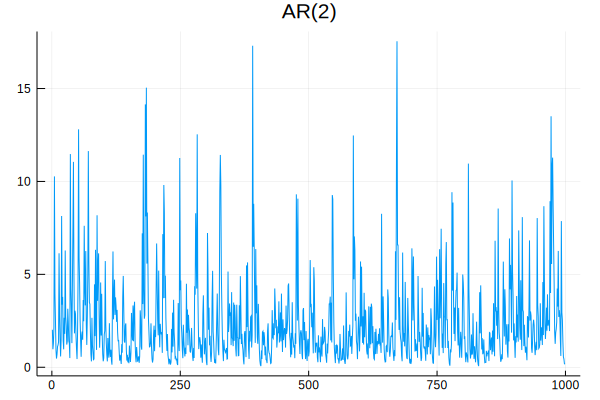

In [85]:
# Plotting
using Plots
pAR = plot(WMSEs, title="AR($ARorder)", label="")
plot(pAR)

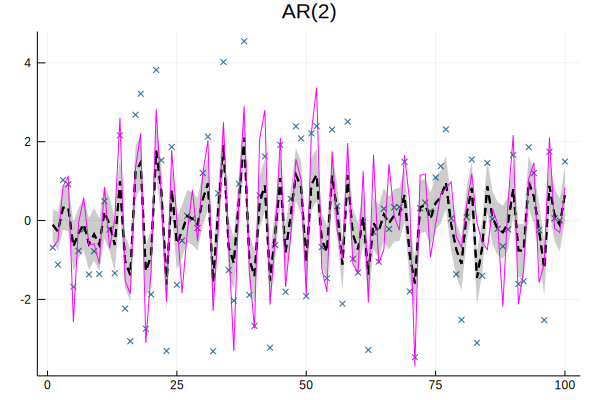

In [86]:
from = 1
upto = 100 # limit for building a graph 
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[from:upto], estimated[from:upto]], fillrange=[estimated[from:upto] -
      scale .* sqrt.(v_x[from:upto]), estimated[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

In [87]:
sum(WMSEs)

2388.013253088001